Samobójstwa na świecie - analiza statystyczna
Projekt z rachunku prawdopodobieństwa i statystyki 2022/2023

# Wprowadzenie

# Opis danych statystycznych

## Źródło
Projekt został opracowany, dzięki danym z portalu [Kaggle](https://www.kaggle.com): [Suicide rates overview](https://www.kaggle.com/datasets/russellyates88/suicide-rates-overview-1985-to-2016).

## Wczytanie bazy danych

In [1]:
import sqlite3

conn = sqlite3.connect("../data/suicides.db")
cur = conn.cursor()

## Czyszczenie zbioru danych
Wykorzystane dane są w dobrym stanie, kolumna `hdi_per_year`, jedna z 12 kolumn, posiadała tylko braki danych w ponad 19 tys. wierszy, co jest bardzo olbrzymim ubytkiem i budzi niepewność przy analizie. Sposobów na poradzenie sobie z tym było kilka:
- wstawieniem jakieś stałej, np. 0;
- wstawieniem średniej arytmetycznej lub mediany z pozostałych znanych wartości;
- wytworzenie pewnego modelu, który pozwoliłby na korelację tej kolumny z pozostałymi danymi, dzięki temu umożliwiłby relatywnie pewne przybliżenie;
- usunięcie niepełnych wierszy;
- usunięcie kolumny `hdi_per_year`.

Ostatecznie usunięta została po prostu kolumna, ponieważ zbyt duży odsetek nieznanych wartości uniemożliwiłby na dobre wykorzystanie jakiegoś wskaźnika położenia jako zamiennika, a także kolumna ta nie była kluczowa do dalszej analizy - mimo tego, że jest ciekawą zmienną. Dodatkowo została usunięta kolumna `country_year`, która była połączeniem 2 kolumn.

Dane zostały także wyczyszczone o państwa, które nie posiadały przynajmniej 20 zapisanych danych statystycznych z okresu 1990-2015.

In [2]:
# cur.execute("""
#     DELETE FROM suicides WHERE country IN (
#         SELECT country FROM (
#             SELECT DISTINCT country, year FROM suicides WHERE year BETWEEN 1990 AND 2015
#         )
#         GROUP BY country
#         HAVING COUNT(*) < 20
#     )
# """)

print("3,068 rows affected")

3,068 rows affected


Usuniętych zostało 24 krajów:
- Albania
- Aruba
- Azerbejdżan
- Bahrajn
- Bośnia i Hercegowina
- Cypr
- Czarnogóra
- Fidżi
- Filipiny
- Jamajka
- Katar
- Kiribati
- Makau
- Malediwy
- Nikaragua
- Oman
- Republika Zielonego Przylądka
- Saint Kitts i Nevis
- San Marino
- Serbia
- Seszele
- Sri Lanka
- Turcja
- Zjednoczone Emiraty Arabskie

W dalszej części analizy będę stosować się do informacji głównie między 1990 a 2015 rokiem, ponieważ pozostałe lata nie są aż tak dobrze opisane dla każdego z wylistowanych państw.

In [3]:
years_range = "year BETWEEN 1990 AND 2015"

## Opis bazy danych
Początkowo baza danych zawierała 27800 wierszy, po czyszczeniu danych ta liczba uległa redukcji do 24752, dodatkowo znaczna część analizy przeprowadzona jest na latach 1990-2015, ze względu na zmniejszony zbiór danych na krańcach pierwotnego zakresu. Dane działają w oparciu o lokalnę bazę danych `SQLite 3.40.1`. W bazie znajduje się tylko 1 tabela `suicides`, która opisuje zależność samobójstw dokonanych globalnie z podziałem na poszczególne państwa.<br><br>
`suicides`
- `country` - nazwa państwa (`TEXT`)
- `year` - rok (`INTEGER`)
- `sex` - płeć (`TEXT`)
    - `female` - kobieta
    - `male` - mężczyzna
- `age` - grupa wiekowa osób (`TEXT`)
    - `5-14 years`
    - `15-24 years`
    - `25-34 years`
    - `35-54 years`
    - `55-74 years`
    - `75+ years`
- `suicides_no` - liczba dokonanych samobójstw (`INTEGER`)
- `population` - populacja (`INTEGER`)
- `suicides_per_100k` - liczba samobójstw na 100 tys. osób (`REAL`)
- `gdp_per_year` - roczne PKB (`REAL`)
- `gdp_per_capita` - roczne PKB na osobę (`REAL`)
- `generation` - nazwa generacji społecznej (`TEXT`)
    - `Boomers`
    - `G.I. Generation`
    - `Generation X`
    - `Generation Z`
    - `Millenials`
    - `Silent`

# Analiza eksploracyjna

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as cl

## Semi-globalna liczba samobójstw dokonanych w latach 1990-2015

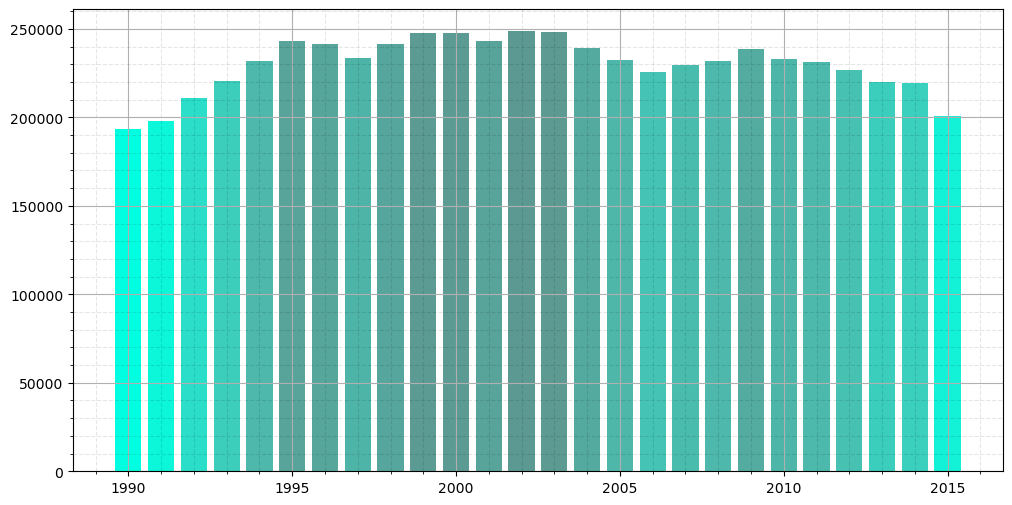

In [5]:
res = cur.execute(f"""
    SELECT year, SUM(suicides_no) 
    FROM suicides
    WHERE {years_range}
    GROUP BY year
    ORDER BY year DESC
""")
x, y = zip(*res.fetchall())
y_min, y_max = min(y), max(y)

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x, y, color=[cl.hsv_to_rgb((.48, 1 - (x - y_min) / (y_max - y_min) * .6, 1 - (x - y_min) / (y_max - y_min) * .4)) for x in y])

plt.minorticks_on()
plt.grid(which="major")
plt.grid(which="minor", linestyle="--", color="#000000", alpha=.1)

plt.show()

Wskaźniki i położenia rozproszenia

In [6]:
data = [[
    round(np.mean(y), 1),
    np.median(y),
    round(np.std(y), 1),
    round(np.mean(np.absolute(y - np.mean(y))), 1)
]]
pd.DataFrame(data, columns=["Wartość średnia", "Mediana", "Oddchylenie standardowe", "Oddchylenie przeciętne"], index=['']).transpose()

,
Wartość średnia,229950.7
Mediana,232243.5
Oddchylenie standardowe,15259.0
Oddchylenie przeciętne,11872.3


Na powyższym wykresie można zaobserować spadki na początku lat 90. jak i także po 2011 roku. Główną przyczyną mniejszej liczby śmierci jest najprawdopodobniej zmniejszona ilość zebranych danych na poziomie ok. 10-15%.

## 10 największych państw pod względem dokonanych samobójstw w latach 1990-2015

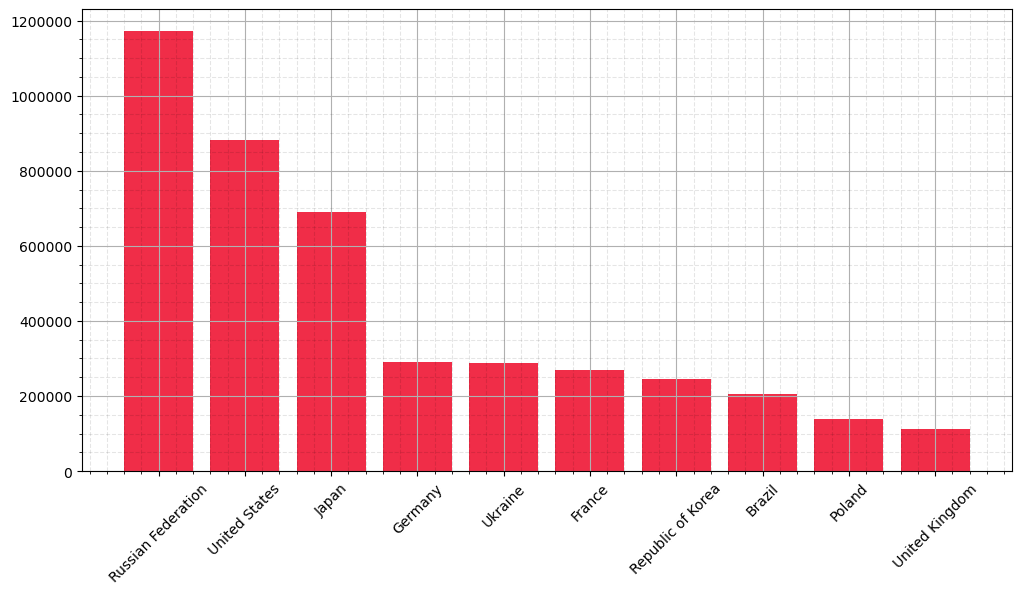

In [7]:
res = cur.execute(f"""
    SELECT country, SUM(suicides_no) 
    FROM suicides
    WHERE {years_range}
    GROUP BY country
    ORDER BY SUM(suicides_no) DESC
""")
countries, y = zip(*res.fetchall()[:10])

fig, ax = plt.subplots(figsize=(12, 6))
ax.ticklabel_format(useOffset=False, style="plain")
ax.bar(countries, y, color="#f02d48")

plt.xticks(rotation=45)
plt.minorticks_on()
plt.grid(which="major")
plt.grid(which="minor", linestyle="--", color="#000000", alpha=.1)

plt.show()

Wskaźniki położenia i rozproszenia (roczne)

In [8]:
res = cur.execute(f"""
    SELECT country, SUM(suicides_no)
    FROM suicides
    WHERE country IN (
        SELECT country
        FROM suicides
        WHERE {years_range}
        GROUP BY country
        ORDER BY SUM(suicides_no) DESC
        LIMIT 10
    ) AND {years_range}
    GROUP BY country, year
    ORDER BY country, year
""")
res = res.fetchall()

suicides_by_country = [[y for x, y in res if x == c] for c in countries]
data = [
    [
        c,
        round(np.mean(suicides_by_country[i]), 1),
        np.median(suicides_by_country[i]),
        round(np.std(suicides_by_country[i]), 1),
        round(np.mean(np.absolute(suicides_by_country[i] - np.mean(suicides_by_country[i]))), 1)
    ] for i, c in enumerate(countries)
]
pd.DataFrame(data, columns=["Państwo", "Wartość średnia", "Mediana", "Oddchylenie standardowe", "Oddchylenie przeciętne"], index=range(1, 11))

,Państwo,Wartość średnia,Mediana,Oddchylenie standardowe,Oddchylenie przeciętne
1,Russian Federation,45070.0,45862.5,11185.8,9880.7
2,United States,33934.1,31561.0,4389.2,3745.1
3,Japan,26569.6,28949.0,4244.8,3917.4
4,Germany,11202.4,11114.0,1383.3,1154.0
5,Ukraine,11570.5,11256.0,2303.7,2025.5
6,France,10744.9,10643.0,761.4,592.7
7,Republic of Korea,9435.0,9632.0,4251.5,3863.5
8,Brazil,7865.9,7774.5,1807.5,1537.6
9,Poland,5795.8,5820.5,366.2,291.8
10,United Kingdom,4343.7,4302.5,256.6,210.2


## 10 najmniejszych państw pod względem dokonanych samobójstw w latach 1990-2015

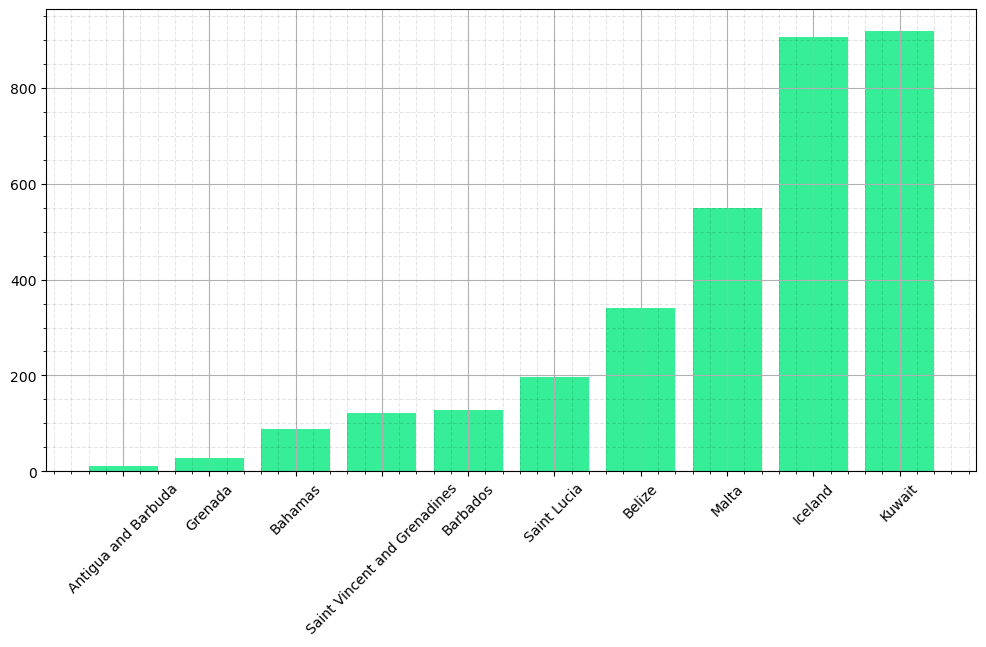

In [9]:
res = cur.execute(f"""
    SELECT country, SUM(suicides_no) 
    FROM suicides
    WHERE {years_range}
    GROUP BY country
    ORDER BY SUM(suicides_no)
""")
countries, y = zip(*res.fetchall()[:10])

fig, ax = plt.subplots(figsize=(12, 6))
ax.ticklabel_format(useOffset=False, style="plain")
ax.bar(countries, y, color="#35ee97")

plt.xticks(rotation=45)
plt.minorticks_on()
plt.grid(which="major")
plt.grid(which="minor", linestyle="--", color="#000000", alpha=.1)

plt.show()

Wskaźniki położenia i rozproszenia (roczne)

In [10]:
res = cur.execute(f"""
    SELECT country, SUM(suicides_no)
    FROM suicides
    WHERE country IN (
        SELECT country
        FROM suicides
        WHERE {years_range}
        GROUP BY country
        ORDER BY SUM(suicides_no)
        LIMIT 10
    ) AND {years_range}
    GROUP BY country, year
    ORDER BY country, year
""")
res = res.fetchall()

suicides_by_country = [[y for x, y in res if x == c] for c in countries]
data = [[
        c,
        round(np.mean(suicides_by_country[i]), 1),
        np.median(suicides_by_country[i]),
        round(np.std(suicides_by_country[i]), 1),
        round(np.mean(np.absolute(suicides_by_country[i] - np.mean(suicides_by_country[i]))), 1)
    ] for i, c in enumerate(countries)
]
pd.DataFrame(data, columns=["Państwo", "Wartość średnia", "Mediana", "Oddchylenie standardowe", "Oddchylenie przeciętne"], index=range(1, 11))

,Państwo,Wartość średnia,Mediana,Oddchylenie standardowe,Oddchylenie przeciętne
1,Antigua and Barbuda,0.5,0.0,0.7,0.6
2,Grenada,1.3,1.0,1.7,1.3
3,Bahamas,4.2,4.0,2.6,2.0
4,Saint Vincent and Grenadines,5.5,5.0,2.8,2.3
5,Barbados,6.4,3.0,6.7,6.2
6,Saint Lucia,8.2,8.0,3.7,2.9
7,Belize,13.6,14.0,7.6,5.9
8,Malta,21.1,20.0,7.6,6.4
9,Iceland,34.8,34.0,6.9,5.5
10,Kuwait,41.7,42.5,11.6,9.2


## Liczba dokonanych samobójstw w Polsce między 1990-2015 (z podziałem na płci)

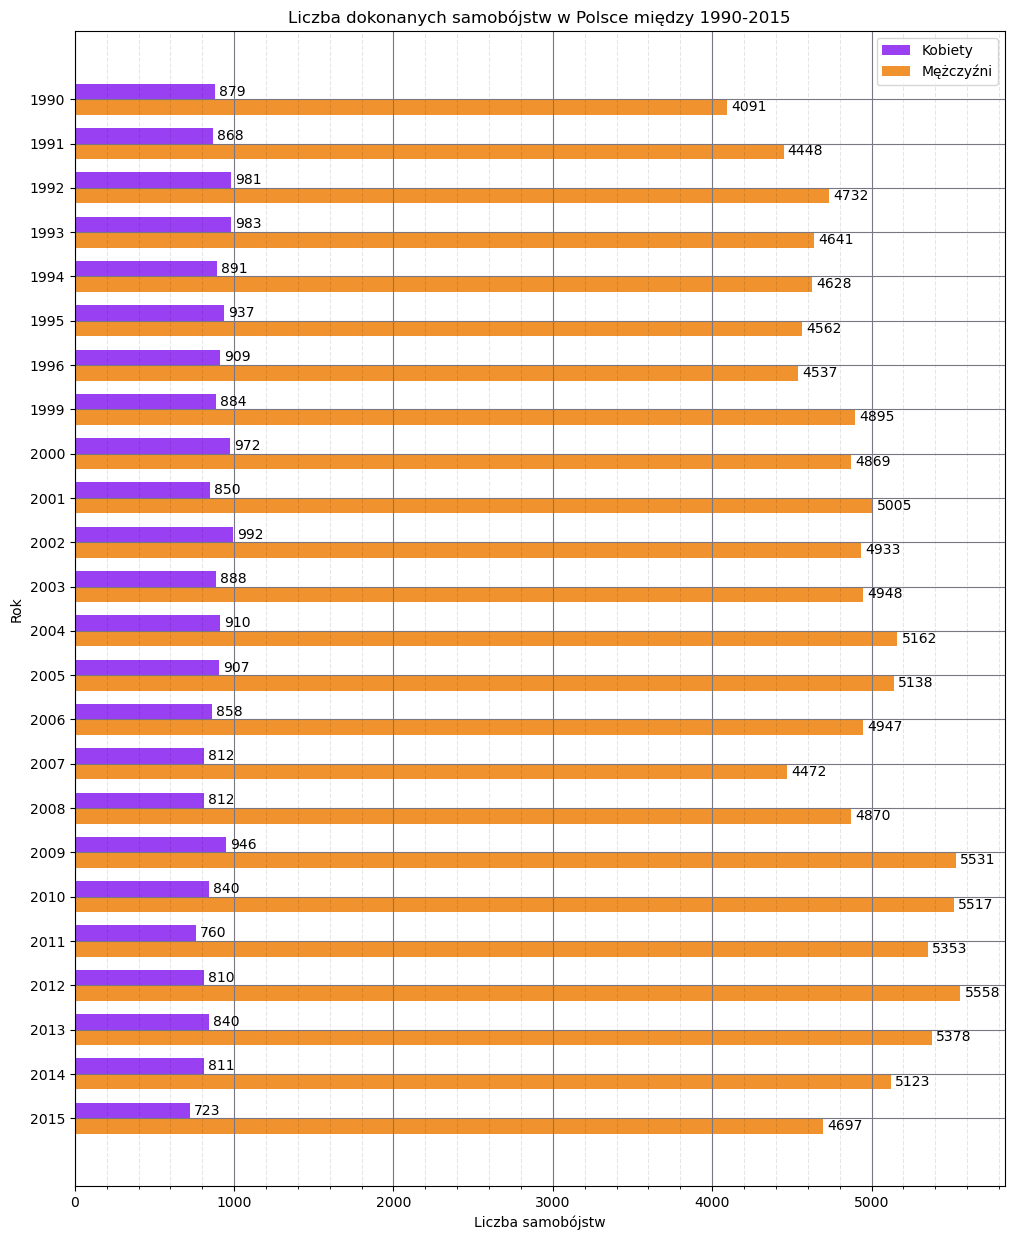

In [11]:
res = cur.execute("""
    SELECT sex, SUM(suicides_no)
    FROM suicides
    WHERE country = 'Poland'
    GROUP BY year, sex
    ORDER BY year
""")
res = res.fetchall()
years = cur.execute("SELECT DISTINCT year FROM suicides WHERE country = 'Poland'").fetchall()
years = [y[0] for y in years]
suicides_female = [x for s, x in res if s == "female"]
suicides_male = [x for s, x in res if s == "male"]

x = np.arange(len(years))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 15))
rects1 = ax.barh(x - width/2, suicides_female, width, label="Kobiety", color="#9940f2")
rects2 = ax.barh(x + width/2, suicides_male, width, label="Mężczyźni", color="#f0922d")

# Axis formatting
ax.ticklabel_format(useOffset=False, style="plain")
ax.set_title("Liczba dokonanych samobójstw w Polsce między 1990-2015")
ax.set_ylabel("Rok")
ax.set_xlabel("Liczba samobójstw")
ax.invert_yaxis()
ax.set_yticks(x, years)
ax.tick_params(axis="y", which="minor", left=False)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

# Grid formatting
plt.minorticks_on()
plt.grid(which="major", color="#7a7784")
plt.grid(which="minor", axis="x", linestyle="--", color="#000000", alpha=.1)

plt.show()

Wskaźniki położenia i rozproszenia

In [12]:
data = [
    [
        round(np.mean(suicides_female), 1),
        np.median(suicides_female),
        round(np.std(suicides_female), 1),
        round(np.mean(np.absolute(suicides_female - np.mean(suicides_female))), 1)
    ],
    [
        round(np.mean(suicides_male), 1),
        np.median(suicides_male),
        round(np.std(suicides_male), 1),
        round(np.mean(np.absolute(suicides_male - np.mean(suicides_male))), 1)
    ]
]
pd.DataFrame(data, columns=["Wartość średnia", "Mediana", "Oddchylenie standardowe", "Oddchylenie przeciętne"], index=["Kobiety", "Mężczyźni"]).transpose()

,Kobiety,Mężczyźni
Wartość średnia,877.6,4918.1
Mediana,881.5,4914.0
Oddchylenie standardowe,69.1,372.5
Oddchylenie przeciętne,55.8,298.0


Dysproporcja między samobójstwami dokonanych przez kobiety a mężczyzn jest zaskakująca, zarówno w Polsce jak i na świecie. Średni udział kobiet do wszystkich dokonanych samobójstw w Polsce wynosi ok. 15%, natomiast na świecie ok. 23% - zatem w Polsce statystycznie więcej mężczyzn decyduje się na drastyczne kroki w postaci skrócenia swego życia.

## Liczba dokonanych samobójstw w latach 1990-2015 z podziałem na generacje

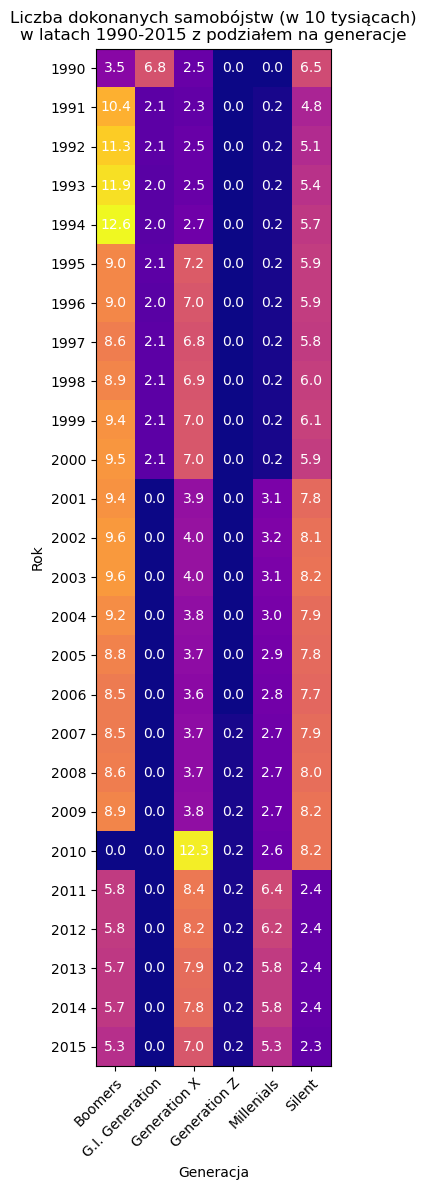

In [17]:
res = cur.execute(f"""
    SELECT generation, year, SUM(suicides_no)
    FROM suicides
    WHERE {years_range}
    GROUP BY generation, year
""").fetchall()
generations = [x[0] for x in cur.execute("SELECT DISTINCT generation FROM suicides ORDER by generation").fetchall()]
years = [x[0] for x in cur.execute(f"SELECT DISTINCT year FROM suicides WHERE {years_range} ORDER BY year").fetchall()]

suicides = np.empty((len(years), len(generations)))
for i, gen in enumerate(generations):
    for j, yr in enumerate(years):
        filtered_res = [no for g, y, no in res if g == gen and y == yr]
        no = filtered_res[0] if filtered_res else 0
        suicides[j, i] = round(no / 1000) / 10

fig, ax = plt.subplots(figsize=(12, 12))
im = ax.imshow(suicides, cmap="plasma")

# Axis formatting
ax.set_xticks(np.arange(len(generations)), labels=generations)
ax.set_yticks(np.arange(len(years)), labels=years)
ax.set_ylabel("Rok")
ax.set_xlabel("Generacja")

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(years)):
    for j in range(len(generations)):
        text = ax.text(j, i, suicides[i, j],
                       ha="center", va="center", color="w")

ax.set_title("Liczba dokonanych samobójstw (w 10 tysiącach)\nw latach 1990-2015 z podziałem na generacje")
fig.tight_layout()
plt.show()

In [ ]:
Wskaźniki położenia i rozproszenia

In [23]:
data = []
for i, gen in enumerate(generations):
    filtered_res = [no for g, y, no in res if g == gen]
    data.append((
        gen,
        round(np.mean(filtered_res), 1),
        np.median(filtered_res),
        round(np.std(filtered_res), 1),
        round(np.mean(np.absolute(filtered_res - np.mean(filtered_res))), 1)
    ))

pd.DataFrame(data, columns=["Generacja", "Wartość średnia", "Mediana", "Oddchylenie standardowe", "Oddchylenie przeciętne"], index=range(1, len(generations) + 1))

,Generacja,Wartość średnia,Mediana,Oddchylenie standardowe,Oddchylenie przeciętne
1,Boomers,85302.6,89062.0,21122.4,15630.9
2,G.I. Generation,25094.5,20862.0,13601.3,7818.8
3,Generation X,53920.7,39907.5,24754.3,22138.0
4,Generation Z,1693.6,1700.0,74.3,65.4
5,Millenials,24113.7,27403.0,21344.0,17841.4
6,Silent,59619.0,59726.5,20407.3,16173.2


Najwięcej osób w latach 1990-2015, którzy popełnili samobójstwo to ludzie z generacji _Baby boomers_ (lata 1946-1964), _Silent_ (lata 1928-1945) oraz _Generation X_ (lata 1965-1980). Nie jest to wielkim zaskoczeniem, ponieważ te osoby w tych latach dorastały lub były dorosłe. Na powyższym zestawieniu widać wymianę pokoleń i zmianę generacji, w latach 2010-2015 coraz więcej osób z generacji _X_ popełniło samobójstw na rzecz generacji _Boomers_ i _Silent_. Można także zaobserować pewne anomalie w danych w postaci skoków między poszczególnymi latami, a także zmniejszonej lub zerowej liczbie zgonów.

# Opracowanie modelu statystycznego

# Podsumowanie